In [1]:
%load_ext autoreload
%autoreload 2

In [123]:
import cv2
import numpy as np
import rawpy
import imutils

import matplotlib.pyplot as plt

from photo.film import detect, show, crop, rotate

# To dos
- Close rectangles (e.g., for very under-exposed areas near the edges of a frame)
  - See `epsilon` in `cv2.approxPolyDP`
- Add aspect ratio filter (area is not sufficient)

In [3]:
path = "/Users/dsuo/Downloads/2021-01-19-0001.dng"
fmt = "35"
with rawpy.imread(path) as raw:
    rgb = raw.postprocess()

In [4]:
rgb.shape

(17600, 13600, 3)

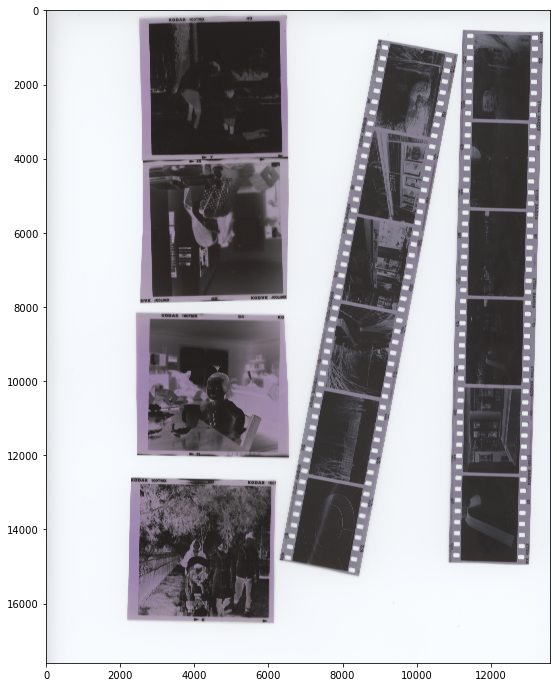

In [12]:
plt.figure(figsize=(16, 12))
plt.imshow(rgb)

In [124]:
paths, rotations = detect(rgb, fmt="35", area_threshold=0.1, dpi=1600)

100%|██████████| 32383/32383 [00:00<00:00, 44508.12it/s]


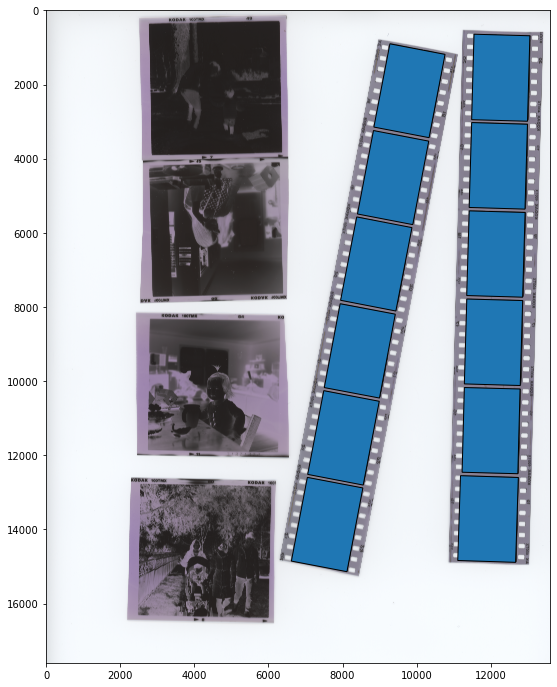

In [21]:
show(rgb, paths)

In [126]:
cropped = crop(rgb, paths)

100%|██████████| 12/12 [00:00<00:00, 56616.03it/s]


In [129]:
rotated = rotate(cropped, rotations)

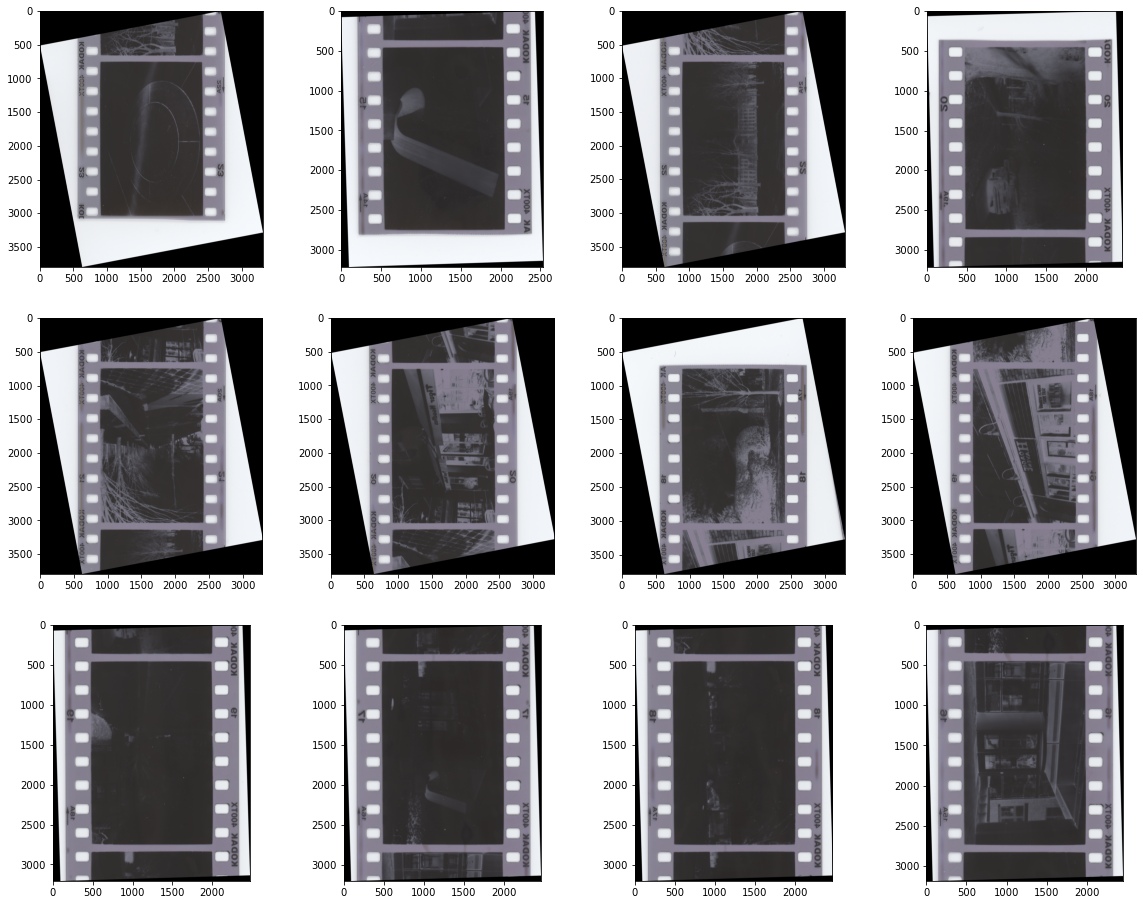

In [138]:
fig, axs = plt.subplots(3, 4, figsize=(20, 16))

for i, preview in enumerate(rotated):
    axs[i // 4, i % 4].imshow(preview, cmap="gray")

In [150]:
finals = []

for preview in rotated:
    p, r = detect(preview,  fmt="35", area_threshold=0.1, dpi=1600)
    finals.append(crop(preview, p, width=36/25.4, height=24/25.4, pad=0.1, dpi=1600)[0])

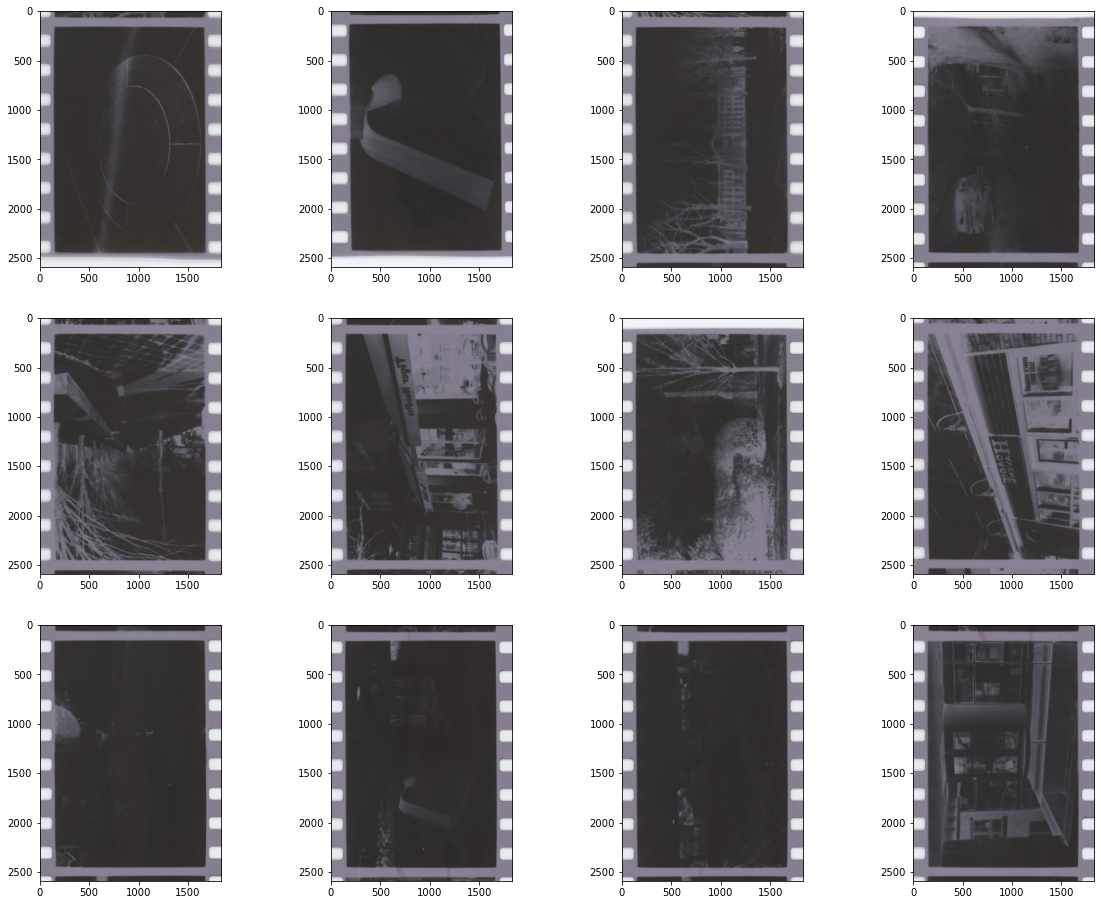

In [151]:
fig, axs = plt.subplots(3, 4, figsize=(20, 16))

for i, final in enumerate(finals):
    axs[i // 4, i % 4].imshow(final, cmap="gray")

In [152]:
for final in finals:
    print(final.shape)

(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
(2587, 1831, 3)
